<a href="https://colab.research.google.com/github/victorviro/ML_algorithms_python/blob/master/Unsupervised_Learning_Techniques_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Learning Techniques

Although most of the applications of Machine Learning today are based on supervised learning, the vast majority of the available data is actually unlabeled: we have the input features $\boldsymbol{X}$, but we do not have the labels $\boldsymbol{y}$. There is a huge potential in unsupervised learning.

We have already see the most common unsupervised learning task: [dimensionality reduction](https://github.com/victorviro/ML_algorithms_python/blob/master/Dimensionality_reduction_algorithms.ipynb). In this notebook, we will look another common unsupervised learning task:

- *Clustering*: the goal is to group similar instances together into clusters. This is a great tool for data analysis, customer segmentation, recommender systems, search engines, image segmentation, semi-supervised learning, dimensionality reduction, and more.






## Clustering

### Introduction to Clustering





As you enjoy a hike in the mountains, you stumble upon a plant you have never seen before. You look around and you notice a few more. They are not perfectly identical, yet they are sufficiently similar for you to know that they most likely belong to the same species (or at least the same genus). You may need a botanist to tell you what species that is, but you certainly don’t need an expert to identify groups of similar-looking objects. This is called *clustering*: it is the task of identifying similar instances and assigning them to clusters, i.e., groups of similar instances.

Just like in classification, each instance gets assigned to a group. However, this is an unsupervised task. Consider the next figure:

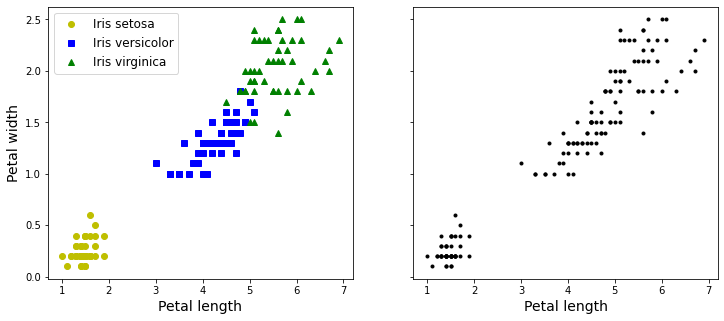

In [1]:
#@title

from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

data = load_iris()
X = data.data
y = data.target
data.target_names

plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)

plt.show()


On the left is the iris dataset, where each instance’s species (i.e., its class) is represented with a different marker. It is a labeled dataset, for which classification algorithms such as Logistic Regression, SVMs or Random Forest classifiers are well suited. On the right is the same dataset, but without the labels, so you cannot use a classification algorithm anymore. This is where clustering algorithms step in: many of them can easily detect the
top left cluster. It is also quite easy to see with our own eyes, but it is not so obvious that the lower right cluster is actually composed of two distinct sub-clusters. That said, the dataset actually has two additional features (sepal length and width), not represented here, and clustering algorithms can make good use of all features, so in fact they identify the three clusters fairly well (e.g., using a Gaussian mixture model, only 5 instances out of 150 are assigned to the wrong cluster).

Clustering is used in a wide variety of applications, including:

- For customer segmentation: you can cluster your customers based on their purchases, their activity on your website, and so on. This is useful to understand who your customers are and what they need, so you can adapt your products and marketing campaigns to each segment. For example, this can be useful in recommender systems to suggest content that other users in the same cluster enjoyed.

- For data analysis: when analyzing a new dataset, it is often useful to first discover clusters of similar instances, as it is often easier to analyze clusters separately.

- As a dimensionality reduction technique: once a dataset has been clustered, it is usually possible to measure each instance’s affinity with each cluster (affinity is any measure of how well an instance fits into a cluster). Each instance’s feature vector $\boldsymbol{x}$ can then be replaced with the vector of its cluster affinities. If there are $k$ clusters, then this vector is $k$ dimensional. This is typically much lower dimensional than the original feature vector, but it can preserve enough information for further processing.

- For *anomaly detection* (also called *outlier detection*): any instance that has a low affinity to all the clusters is likely to be an anomaly. For example, if you have clustered the users of your website based on their behavior, you can detect users with unusual behavior, such as an unusual number of requests per second, and so on. Anomaly detection is particularly useful in detecting defects in manufacturing, or for fraud detection.

- For semi-supervised learning: if you only have a few labels, you could perform clustering and propagate the labels to all the instances in the same cluster. This can greatly increase the amount of labels available for a subsequent supervised learning algorithm, and thus improve its performance.

- For search engines: for example, some search engines let you search for images that are similar to a reference image. To build such a system, you would first apply a clustering algorithm to all the images in your database: similar images would end up in the same cluster. Then when a user provides a reference image, all you need to do is to find this image’s cluster using the trained clustering model, and you can then simply return all the images from this cluster.

- To segment an image: by clustering pixels according to their color, then replacing each pixel’s color with the mean color of its cluster, it is possible to reduce the number of different colors in the image considerably. This technique is used in many object detection and tracking systems, as it makes it easier to detect the contour of each object.

There is no universal definition of what a cluster is: it really depends on the context, and different algorithms will capture different kinds of clusters. For example, some algorithms look for instances centered around a particular point, called a *centroid*. Others look for continuous regions of densely packed instances: these clusters can take on any shape. Some algorithms are hierarchical, looking for clusters of clusters. And the list goes on.

In this section, we will look at two popular clustering algorithms: K-Means and DBSCAN, and we will show some of their applications, such as non-linear dimensionality reduction, semi-supervised learning and anomaly detection.



### K-Means






Consider the unlabeled dataset represented in the next figure: 

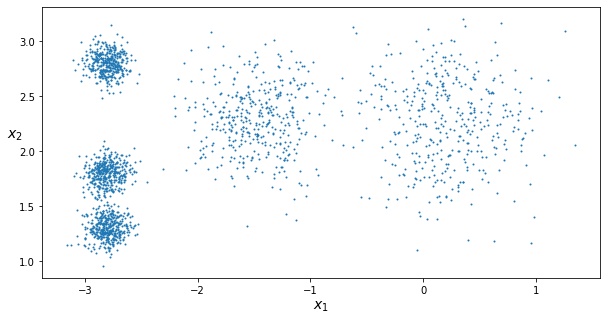

In [2]:
#@title
from sklearn.datasets import make_blobs
import numpy as np
np.random.seed(42)

blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)


plt.figure(figsize=(10, 5))
plot_clusters(X)
plt.show()

You can clearly see 5 blobs of instances. The K-Means algorithm is a simple algorithm capable of clustering this kind of dataset very quickly and efficiently, often in just a few iterations. It was proposed by Stuart Lloyd at the Bell Labs in 1957, but it was only published outside of the company in 1982, in a paper titled “Least square quantization in PCM”. By then, in 1965, Edward W. Forgy had published virtually the same algorithm, so K-Means is sometimes referred to as Lloyd-Forgy.

Let’s train a K-Means clusterer on this dataset. It will try to find each blob’s center and assign each instance to the closest blob:

In [3]:
from sklearn.cluster import KMeans

k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

Note that you have to specify the number of clusters $k$ that the algorithm must find. In this example, it is pretty obvious from looking at the data that $k$ should be set to $5$, but in general it is not that easy. We will discuss this later.

Each instance was assigned to one of the $5$ clusters. In the context of clustering, an instance’s label is the index of the cluster that this instance gets assigned to by the algorithm. The KMeans instance preserves a copy of the labels of the instances it was trained on, available via the `labels_` instance variable:

In [4]:
print(y_pred)
print(y_pred is kmeans.labels_)
print(kmeans.labels_)

[4 1 0 ... 3 0 1]
True
[4 1 0 ... 3 0 1]


We can also take a look at the 5 centroids that the algorithm found:

In [5]:
kmeans.cluster_centers_

array([[ 0.20876306,  2.25551336],
       [-2.80389616,  1.80117999],
       [-1.46679593,  2.28585348],
       [-2.79290307,  2.79641063],
       [-2.80037642,  1.30082566]])

Of course, you can easily assign new instances to the cluster whose centroid is closest:

In [6]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([0, 0, 3, 3], dtype=int32)

If you plot the cluster’s decision boundaries, you get a Voronoi tessellation (next figure (Figure 9-3), where each centroid is represented with an X):


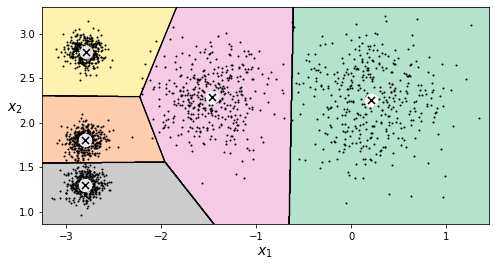

In [7]:
#@title
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

The vast majority of the instances were clearly assigned to the appropriate cluster, but a few instances were probably mislabeled (especially near the boundary between the top left cluster and the central cluster). Indeed, the K-Means algorithm does not behave very well when the blobs have very different diameters since all it cares about when assigning an instance to a cluster is the distance to the centroid.

Instead of assigning each instance to a single cluster, which is called *hard clustering*, it can be useful to just give each instance a score per cluster: this is called *soft clustering*. For example, the score can be the distance between the instance and the centroid, or conversely it can be a similarity score (or affinity) such as the Gaussian Radial Basis Function (introduced [here](https://github.com/victorviro/ML_algorithms_python/blob/master/Support_Vector_Machines_explained.ipynb)). In the `KMeans` class, the `transform()` method measures the distance from each instance to every centroid:

In [8]:
kmeans.transform(X_new)

array([[0.32995317, 2.81093633, 1.49439034, 2.9042344 , 2.88633901],
       [2.80290755, 5.80730058, 4.4759332 , 5.84739223, 5.84236351],
       [3.29399768, 1.21475352, 1.69136631, 0.29040966, 1.71086031],
       [3.21806371, 0.72581411, 1.54808703, 0.36159148, 1.21567622]])

In this example, the first instance in `X_new` is located at a distance of $2.81$ from the first centroid, $0.33$ from the second centroid, $2.90$ from the third centroid, $1.49$ from the fourth centroid and $2.87$ from the fifth centroid. If you have a high-dimensional dataset and you transform it this way, you end up with a $k$-dimensional dataset: this can be a very efficient non-linear dimensionality reduction technique.

You can verify that this is indeed the Euclidian distance between each instance and each centroid:

In [9]:
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2) - kmeans.cluster_centers_, axis=2)

array([[0.32995317, 2.81093633, 1.49439034, 2.9042344 , 2.88633901],
       [2.80290755, 5.80730058, 4.4759332 , 5.84739223, 5.84236351],
       [3.29399768, 1.21475352, 1.69136631, 0.29040966, 1.71086031],
       [3.21806371, 0.72581411, 1.54808703, 0.36159148, 1.21567622]])

#### The K-Means Algorithm

Suppose you were given the centroids: you could easily label all the instances in the dataset by assigning each of them to the cluster whose centroid is closest. Conversely, if you were given all the instance labels, you could easily locate all the centroids by computing the mean of the instances for each cluster. But you are given neither the labels nor the centroids,
so how can you proceed? Well, just start by placing the centroids randomly (e.g., by picking $k$ instances at random and using their locations as centroids). Then label the instances, update the centroids, label the instances, update the centroids, and so on until the centroids stop moving. The algorithm is guaranteed to converge in a finite number of steps (usually quite small), it will not oscillate forever. You can see the algorithm in action in the next figure (Figure 9-4): 



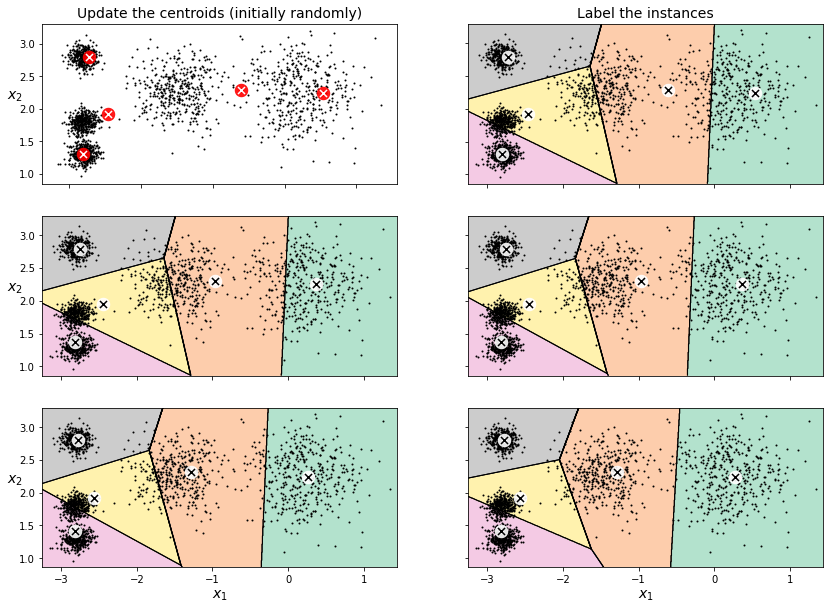

In [10]:
#@title
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=1, random_state=1)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=2, random_state=1)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=3, random_state=1)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

plt.figure(figsize=(14, 10))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

plt.show()

The centroids are initialized randomly (top left), then the instances are labeled (top right), then the centroids are updated (center left),
the instances are relabeled (center right), and so on. As you can see, in just $3$ iterations the algorithm has reached a clustering that seems close to optimal.

**Note**: The computational complexity of the algorithm is generally linear
with regards to the number of instances $m$, the number of clusters $k$ and the number of dimensions $n$. However, this is only true when the data has a clustering structure. If it does not, then in the worst case scenario the complexity can increase exponentially with the number of instances. In practice, however, this rarely happens, and K-Means is generally one of the fastest clustering algorithms.

Unfortunately, although the algorithm is guaranteed to converge, it may not converge to the right solution (i.e., it may converge to a local optimum): this depends on the centroid initialization. For example, the next figure shows two sub-optimal solutions that the algorithm can converge to if you are not lucky with the random initialization step:



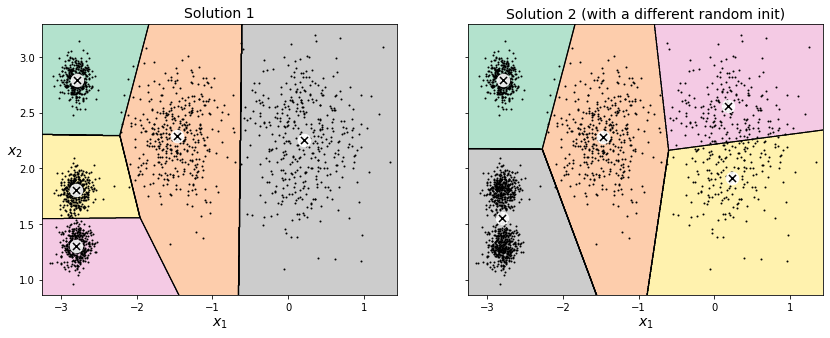

In [11]:
#@title
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(14, 5))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=11)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=2)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random init)")

plt.show()

Let’s look at a few ways you can mitigate this risk by improving the centroid initialization.

#### Centroid Initialization Methods

If you happen to know approximately where the centroids should be (e.g., if you ran another clustering algorithm earlier), then you can set the `init` hyperparameter to a NumPy array containing the list of centroids, and set `n_init` to 1:

In [12]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True,
       init=array([[-3,  3],
       [-3,  2],
       [-3,  1],
       [-1,  2],
       [ 0,  2]]),
       max_iter=300, n_clusters=5, n_init=1, n_jobs=None,
       precompute_distances='auto', random_state=None, tol=0.0001, verbose=0)

Another solution is to run the algorithm multiple times with different random initializations and keep the best solution. This is controlled by the `n_init` hyperparameter: by default, it is equal to $10$, which means that the whole algorithm described earlier actually runs $10$ times when you call `fit()` , and Scikit-Learn keeps the best solution. But how exactly does it know which solution is the best? Well of course it uses a performance metric! It is called the model’s *inertia*: this is the mean squared distance between each instance and its closest centroid. The KMeans class runs the algorithm `n_init` times and keeps the model with the lowest inertia. The model’s inertia is accessible via the `inertia_` instance variable:

In [13]:
kmeans.inertia_

211.5985372581684

You can easily verify that inertia is the sum of the squared distances between each training instance and its closest centroid:

In [14]:
X_dist = kmeans.transform(X)
np.sum(X_dist[np.arange(len(X_dist)), kmeans.labels_]**2)

211.59853725816856

The `score()` method returns the negative inertia. Why negative? Well, it is because a predictor’s `score()` method must always respect the "great is better" rule.



In [15]:
kmeans.score(X)

-211.59853725816856

An important improvement to the K-Means algorithm, called K-Means++, was proposed in a [paper](https://theory.stanford.edu/~sergei/papers/kMeansPP-soda.pdf) by David Arthur and Sergei Vassilvitskii in 2006: they introduced a smarter initialization step that tends to select centroids that are distant from one another, and this makes the K-Means algorithm much less likely to converge to a sub-optimal solution. They showed that the additional computation required for the smarter initialization step is well worth it since it makes it possible to drastically reduce the number of times the algorithm needs to be run to find the optimal solution. Here is the K-Means++ initialization algorithm:
- Take one centroid $\boldsymbol{c}^{(1)}$, chosen uniformly at random from the dataset.

- Take a new centroid $\boldsymbol{c}^{(i)}$, choosing an instance $\boldsymbol{x}^{(i)}$ with probability: $D(\boldsymbol{x}^{(i)})^2\sum_{j=1}^{m}D(\boldsymbol{x}^{(j)})^2$ where $D(\boldsymbol{x}^{(i)})$ is the distance between the instance $\boldsymbol{x}^{(i)}$ and the closest centroid that was already chosen. This probability distribution ensures that instances further away from already chosen centroids are much more likely be selected as centroids.

- Repeat the previous step until all $k$ centroids have been chosen.

The `KMeans` class actually uses this initialization method by default. If you want to force it to use the original method (i.e., picking $k$ instances randomly to define the initial centroids), then you can set the `init` hyperparameter to `"random"`. You will rarely need to do this.

In [16]:
KMeans()

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [17]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)
kmeans.inertia_

211.5985372581684

#### Accelerated K-Means and Mini-batch K-Means

Another important improvement to the K-Means algorithm was proposed in a
[paper](https://www.aaai.org/Papers/ICML/2003/ICML03-022.pdf) by Charles Elkan in 2003. It considerably accelerates the algorithm by avoiding many unnecessary distance calculations: this is achieved by exploiting the [triangle inequality](https://en.wikipedia.org/wiki/Triangle_inequality#:~:text=In%20mathematics%2C%20the%20triangle%20inequality,length%20of%20the%20remaining%20side.) and by keeping track of lower and
upper bounds for distances between instances and centroids. To use Elkan's variant of K-Means, just set `algorithm="elkan"`. Note that it does not support sparse data, so by default, Scikit-Learn uses `"elkan"` for dense data, and `"full"` (the regular K-Means algorithm) for sparse data.






In [18]:
%timeit -n 50 KMeans(algorithm="elkan").fit(X)

50 loops, best of 3: 88.4 ms per loop


In [19]:

%timeit -n 50 KMeans(algorithm="full").fit(X)

50 loops, best of 3: 124 ms per loop


Yet another important variant of the K-Means algorithm was proposed in a
[paper](https://www.eecs.tufts.edu/~dsculley/papers/fastkmeans.pdf) by David Sculley in 2010. Instead of using the full dataset at each iteration, the algorithm is capable of using mini-batches, moving the centroids just slightly at each iteration. This speeds up the algorithm typically by a factor of $3$ or $4 $ and makes it possible to cluster huge datasets that do not fit in memory. Scikit-Learn implements this algorithm in the `MiniBatchKMeans` class. You can just use this class like the `KMeans` class:

In [20]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5)
minibatch_kmeans.fit(X)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=5, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [21]:
minibatch_kmeans.inertia_

211.97203148069426

If the dataset does not fit in memory, the simplest option is to use the `memmap` class, as we did for incremental PCA [here](https://github.com/victorviro/ML_algorithms_python/blob/master/Dimensionality_reduction_algorithms.ipynb). Alternatively, you can pass one mini-batch at a time to the `partial_fit()` method, but this will require much more work, since you will need to perform multiple initializations and select the best one yourself.

Although the Mini-batch K-Means algorithm is much faster than the regular K-
Means algorithm, its inertia is generally slightly worse, especially as the number of clusters increases. You can see this in Figure 9-6: 

![texto alternativo](https://i.ibb.co/4R8Z0FW/mb-kmeans-vs-kmeans.png)

The plot on the left compares the inertias of Mini-batch K-Means and regular K-Means models trained on the previous dataset using various numbers of clusters $k$. The difference between the two curves remains fairly constant, but this difference becomes more and more significant as $k$ increases, since the inertia becomes smaller and smaller. However, in the plot on the right, you can see that Mini-batch K-Means is much faster than regular K-Means, and this difference increases with $k$.

#### Finding the Optimal Number of Clusters

So far, we have set the number of clusters $k$ to 5 because it was obvious by looking at the data that this is the correct number of clusters. But in general, it will not be so easy to know how to set $k$, and the result might be quite bad if you set it to the wrong value. For example, as you can see in the next figure, setting $k$ to 3 or 8 results in fairly bad models:

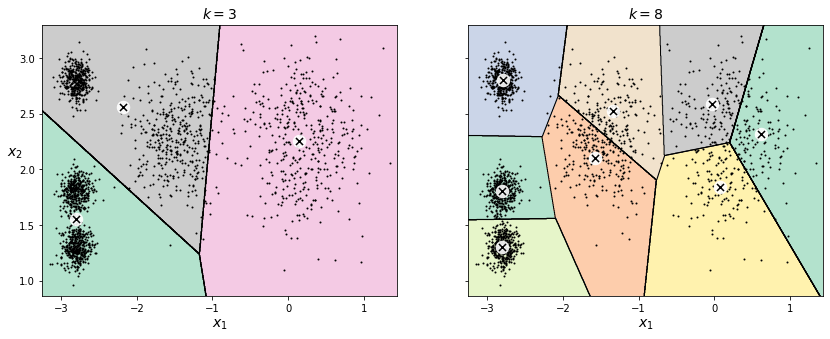

In [22]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
plt.show()

You might be thinking that we could just pick the model with the lowest inertia, right? Unfortunately, it is not that simple. 

In [23]:
print(kmeans_k3.inertia_)
print(kmeans_k8.inertia_)

653.2167190021553
118.41983763508077


The inertia for $k=3$ is $653.2$, which is much higher than for $k=5$ (which was $211.6$), but with $k=8$, the inertia is just $119.1$. The inertia is not a good performance metric when trying to choose $k$ since it keeps getting lower as we increase $k$. Indeed, the more clusters there are, the closer each
instance will be to its closest centroid, and therefore the lower the inertia will be. Let’s plot the inertia as a function of $k$:

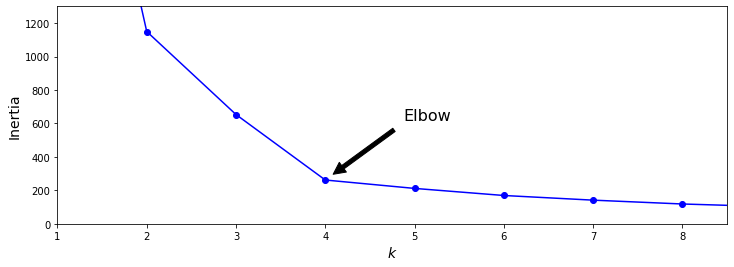

In [24]:
#@title
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(12,4))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
plt.show()

As you can see, the inertia drops very quickly as we increase $k$ up to $4$, but then it decreases much more slowly as we keep increasing $k$. This curve has roughly the shape of an arm, and there is an “elbow” at $k=4$ so if we did not know better, it would be a good choice: any lower value would be dramatic, while any higher value would not help much, and we might just be splitting perfectly good clusters in half for no good reason.

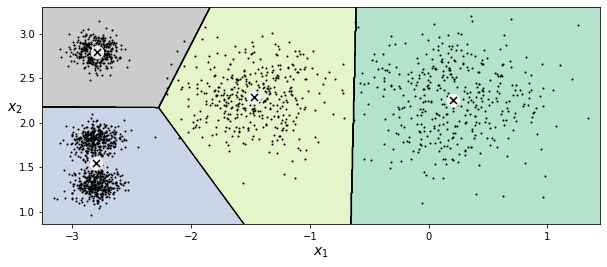

In [25]:
#@title
plt.figure(figsize=(10,4))
plot_decision_boundaries(kmeans_per_k[4-1], X)
plt.show()

Of course in this example, the choice $k=4$ it is not perfect since it means that the two blobs in the lower left will be considered as just a single cluster, but it's a pretty good clustering nonetheless.


This technique for choosing the best value for the number of clusters is rather coarse. A more precise approach (but also more computationally expensive) is to use the *silhouette score*, which is the mean *silhouette coefficient* over all the instances. An instance’s silhouette coefficient is equal to $\frac{(b-a)}{\text{max}(a, b)}$ where $a$ is the mean distance
to the other instances in the same cluster (it is the mean intra-cluster distance), and $b$ is the mean nearest-cluster distance, that is the mean distance to the instances of the next closest cluster (defined as the one that minimizes $b$, excluding the instance’s own cluster). The silhouette coefficient can vary between $-1$ and $+1$: a coefficient close to
$+1$ means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to $0$ means that it is close to a cluster boundary, and finally a coefficient close to $-1$ means that the instance may have been assigned to the wrong cluster. To compute the silhouette score, you can use Scikit-Learn’s `silhouette_score()` function, giving it all the instances in the dataset, and the labels they were assigned:


In [26]:
from sklearn.metrics import silhouette_score

silhouette_score(X, kmeans.labels_)

0.655517642572828

Let’s compare the silhouette scores for different numbers of clusters:

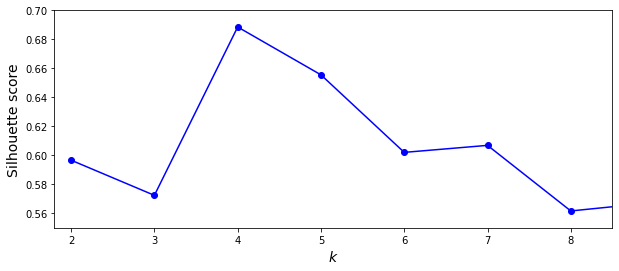

In [27]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]


plt.figure(figsize=(10, 4))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()

As you can see, this visualization is much richer than the previous one: in particular, although it confirms that $k=4$ is a very good choice, it also underlines the fact that $k=5$ is quite good as well, and much better than $k=6$ or $k=7$. This was not visible when comparing inertias.


An even more informative visualization is obtained when you plot every instance’s silhouette coefficient, sorted by the cluster they are assigned to and by the value of the coefficient. This is called a *silhouette diagram*:

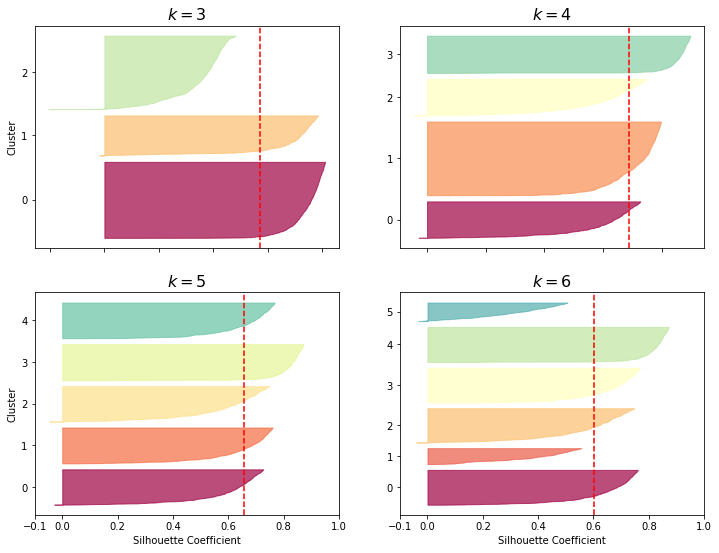

In [28]:
#@title
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib as mpl

plt.figure(figsize=(12, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

The vertical dashed lines represent the silhouette score for each number of clusters. When most of the instances in a cluster have a lower coefficient than this score (i.e., if many of the instances stop short of the dashed line, ending to the left of it), then the cluster is rather bad since this means its instances are much too close to other clusters. We can see that when $k=3$ and when $k=6$, we get bad clusters. But when $k=4$ or $k=5$, the clusters look pretty good (most instances extend beyond the dashed line, to
the right and closer to $1.0$). When $k=4$, the cluster at index 1 (the third from the top), is rather big, while when $k=5$, all clusters have similar sizes, so even though the overall silhouette score from $k=4$ is slightly greater than for $k=5$, it seems like a good idea to use $k=5$ to get clusters of similar sizes.

### Limits of K-Means

Despite its many merits, most notably being fast and scalable, K-Means is not perfect. As we saw, it is necessary to run the algorithm several times to avoid sub-optimal solutions, plus you need to specify the number of clusters, which can be quite a hassle. Moreover, K-Means does not behave very well when the clusters have varying sizes, different densities, or non-spherical shapes. For example, the next figure let's see how K-Means clusters a dataset containing three ellipsoidal clusters of different dimensions, densities and orientations:

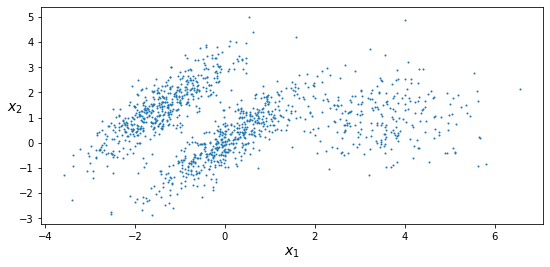

In [29]:
#@title
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]
plt.figure(figsize=(9, 4))
plot_clusters(X)

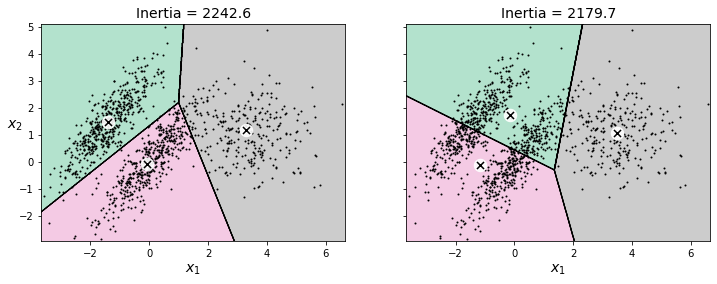

In [30]:
#@title
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

plt.figure(figsize=(12, 4))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)

plt.show()

As you can see, neither of these solutions are any good. The solution on the left is better, but it still chops off $25$% of the middle cluster and assigns it to the cluster on the right. The solution on the right is just terrible, even though its inertia is lower. So depending on the data, different clustering algorithms may perform better. For example, on these types of elliptical clusters, Gaussian mixture models work great.

**Note**: It is important to scale the input features before you run K-Means,
or else the clusters may be very stretched, and K-Means will perform poorly. Scaling the features does not guarantee that all the clusters will be nice and spherical, but it generally improves things.

Now let’s look at a few ways we can benefit from clustering. We will use K-Means.


### Using clustering for image segmentation



*Image segmentation* is the task of partitioning an image into multiple segments. In *semantic segmentation*, all pixels that are part of the same object type get assigned to the same segment. For example, in a self-driving car’s vision system, all pixels that are part of a pedestrian’s image might be assigned to the “pedestrian” segment (there would just be one segment containing all the pedestrians). In instance segmentation, all pixels that are part of the same individual object are assigned to the same segment.
In this case there would be a different segment for each pedestrian. The state of the art in semantic or instance segmentation today is achieved using complex architectures based on convolutional neural networks. Here, we are going to do something much simpler: color segmentation. We will simply assign pixels to the same segment if they have a similar color. In some applications, this may be enough, for example if you want to analyze satellite images to measure how much total forest area there is in a region, color segmentation may be just fine.


First, let’s load the image (see the upper left image in the next figure) using Matplotlib’s `imread()` function:

In [31]:
import requests
from matplotlib.image import imread
img_url = 'https://raw.githubusercontent.com/victorviro/ML_algorithms_python/master/ladybug.png'
response = requests.get(img_url, stream=True)
image = imread(response.raw)
image.shape

(533, 800, 3)

The image is represented as a 3D array: the first dimension’s size is the height, the second is the width, and the third is the number of color channels, in this case red, green and blue (RGB). In other words, for each pixel there is a 3D vector containing the intensities of red, green and blue, each between $0.0$ and $1.0$ (or between $0$ and $255$ if you use `imageio.imread()`). Some images may have less channels, such as gray‐scale images (one channel), or more channels, such as images with an additional alpha channel for transparency, or satellite images which often contain channels for many light frequencies (e.g., infrared). The following code reshapes the array to get a long list of RGB colors, then it clusters these colors using K-Means. For example, it may identify a color cluster for all shades of green. Next, for each color (e.g., dark green), it looks for the mean color of the pixel’s color cluster. For example, all shades of green may be replaced with the same light green color (assuming the mean color of the green cluster is light green). Finally it reshapes this long list of colors to get the same shape as the original image.

In [32]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

This outputs the image shown in the upper right of the next figure. You can experiment with various numbers of clusters, as shown in the figure. When you use less than 8 clusters, notice that the ladybug’s flashy red color fails to get a cluster of its own: it gets merged with colors from the environment. This is due to the fact that the ladybug is quite small, much smaller than the rest of the image, so even though its color is flashy, K-Means fails to dedicate a cluster to it: as mentioned earlier, K-Means prefers clusters of similar sizes.

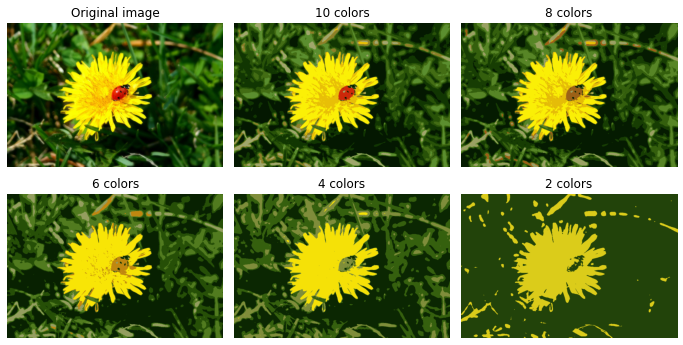

In [33]:
#@title
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

plt.figure(figsize=(12,6))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')
plt.show()

### Using Clustering for Preprocessing

Clustering can be an efficient approach to dimensionality reduction, in particular as a preprocessing step before a supervised learning algorithm. For example, let’s tackle the digits dataset which is a simple MNIST-like dataset containing $1797$ grayscale 8$\times$8 images representing digits $0$ to $9$. First, let’s load the dataset:

In [34]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)

Now, let’s split it into a training set and a test set:

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

Next, let’s fit a Logistic Regression model:

In [36]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Let’s evaluate its accuracy on the test set:

In [37]:
log_reg.score(X_test, y_test)

0.9688888888888889

Okay, that’s our baseline: $96.7$% accuracy. Let’s see if we can do better by using K-Means as a preprocessing step. We will create a pipeline that will first cluster the training set into $50$ clusters and replace the images with their distances to these $50$ clusters, then apply a logistic regression model.

**Note**: Although it is tempting to define the number of clusters to $10$,
since there are $10$ different digits, it is unlikely to perform well,
because there are several different ways to write each digit.

In [38]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)),
])
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('kmeans',
                 KMeans(algorithm='auto', copy_x=True, init='k-means++',
                        max_iter=300, n_clusters=50, n_init=10, n_jobs=None,
                        precompute_distances='auto', random_state=42,
                        tol=0.0001, verbose=0)),
                ('log_reg',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=5000,
                                    multi_class='ovr', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

Now let’s evaluate this classification pipeline:

In [39]:
pipeline.score(X_test, y_test)

0.98

We almost divided the error rate by a factor of 2.


But we chose the number of clusters $k$ completely arbitrarily, we can surely do better. Since K-Means is just a preprocessing step in a classification pipeline, finding a good value for $k$ is much simpler than earlier: there’s no need to perform silhouette analysis or minimize the inertia, the best value of $k$ is simply the one that results in the best classification performance during cross-validation. Let’s use `GridSearchCV` to find the optimal number of clusters:

In [40]:
from sklearn.model_selection import GridSearchCV

param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits
[CV] kmeans__n_clusters=2 ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................. kmeans__n_clusters=2, total=   0.2s
[CV] kmeans__n_clusters=2 ............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ............................. kmeans__n_clusters=2, total=   0.2s
[CV] kmeans__n_clusters=2 ............................................
[CV] ............................. kmeans__n_clusters=2, total=   0.2s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.3s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.3s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.3s
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total=   0.3s
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total=   0.3s
[CV] kmeans__n_clusters=4 ............................................
[CV] .

[Parallel(n_jobs=1)]: Done 294 out of 294 | elapsed: 25.7min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('kmeans',
                                        KMeans(algorithm='auto', copy_x=True,
                                               init='k-means++', max_iter=300,
                                               n_clusters=50, n_init=10,
                                               n_jobs=None,
                                               precompute_distances='auto',
                                               random_state=42, tol=0.0001,
                                               verbose=0)),
                                       ('log_reg',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                      

Let’s look at best value for $k$, and the performance of the resulting pipeline:

In [41]:
grid_clf.best_params_

{'kmeans__n_clusters': 57}

With $k=90$ clusters, we get a small accuracy boost, reaching 98.4% accuracy on the test set.

In [42]:
grid_clf.score(X_test, y_test)

0.98

### Using Clustering for Semi-Supervised Learning

Another use case for clustering is in semi-supervised learning, when we have plenty of unlabeled instances and very few labeled instances. Let’s train a logistic regression model on a sample of 50 labeled instances from the previous digits dataset:

In [43]:
n_labeled = 50

log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

What is the performance of this model on the test set?

In [44]:
log_reg.score(X_test, y_test)

0.8333333333333334

The accuracy is just $83.3$%: it should come as no surprise that this is much lower than earlier, when we trained the model on the full training set. Let’s see how we can do better. First, let’s cluster the training set into $50$ clusters, then for each cluster let’s find the image closest to the centroid. We will call these images the representative images:

In [45]:
k = 50
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

The next figure shows these 50 representative images:



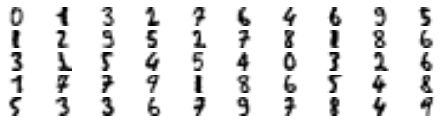

In [46]:
#@title
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

plt.show()

Now let’s look at each image and manually label it:

In [47]:
y_representative_digits = np.array([
    0, 1, 3, 2, 7, 6, 4, 6, 9, 5,
    1, 2, 9, 5, 2, 7, 8, 2, 8, 6,
    3, 1, 5, 4, 5, 4, 0, 3, 2, 6,
    1, 7, 7, 9, 1, 8, 6, 5, 4, 8,
    5, 3, 3, 6, 7, 9, 7, 8, 4, 9])

Now we have a dataset with just $50$ labeled instances, but instead of being completely random instances, each of them is a representative image of its cluster. Let’s see if the performance is any better:

In [48]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.9177777777777778

We jumped from $83.3$% accuracy to $91.7$%, although we are still only training the model on $50$ instances. Since it is often costly and painful to label instances, especially when it has to be done manually by experts, it is a good idea to label representative instances rather than just random instances.


But perhaps we can go one step further: what if we propagated the labels to all the other instances in the same cluster? This is called label propagation:

In [49]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

Now let’s train the model again and look at its performance:

In [50]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train_propagated)
log_reg.score(X_test, y_test)

0.9311111111111111

We got a tiny little accuracy boost. Better than nothing, but not astounding. The problem is that we propagated each representative instance’s label to all the instances in the same cluster, including the instances located close to the cluster boundaries, which are more likely to be mislabeled. Let’s see what happens if we only propagate the labels to the $20$% of the instances that are closest to the centroids:

In [51]:
percentile_closest = 20

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1


partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

Now let’s train the model again on this partially propagated dataset:

In [52]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg.score(X_test, y_test)

0.8955555555555555

We generally get better performance although this is not the case.
However, the propagated labels are actually pretty good, their accuracy is aproximately $97$%:

In [53]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])

0.972318339100346

#### Active learning


To continue improving your model and your training set, the next step could be to do a few rounds of active learning: this is when a human expert interacts with the learning algorithm, providing labels when the algorithm needs them. There are many different strategies for active learning, but one of the most common ones is called *uncertainty sampling*:

- The model is trained on the labeled instances gathered so far, and this model is used to make predictions on all the unlabeled instances.

- The instances for which the model is most uncertain (i.e., when its estimated probability is lowest) must be labeled by the expert.

- Then you just iterate this process again and again, until the performance
improvement stops being worth the labeling effort.

Other strategies include labeling the instances that would result in the largest model change, or the largest drop in the model’s validation error, or the instances that different models disagree on (e.g., an SVM, a Random Forest, and so on).

Let’s take a look at DBSCAN, another popular clustering algorithm that illustrates a very different approach based on local density estimation. This approach allows the algorithm to identify clusters of arbitrary shapes.

### DBSCAN

This algorithm defines clusters as continuous regions of high density. It is actually quite simple:

- For each instance, the algorithm counts how many instances are located within a small distance $\varepsilon$ (epsilon) from it. This region is called the instance’s $\varepsilon$-*neighborhood*.

- If an instance has at least `min_samples` instances in its $\varepsilon$-neighborhood (including itself), then it is considered a *core instance*. In other words, core instances are those that are located in dense regions.

- All instances in the neighborhood of a core instance belong to the same cluster. This may include other core instances, therefore a long sequence of neighboring core instances forms a single cluster.

- Any instance that is not a core instance and does not have one in its neighborhood is considered an anomaly.


This algorithm works well if all the clusters are dense enough, and they are well separated by low-density regions. The `DBSCAN` class in Scikit-Learn is as simple to use as you might expect. Let’s test it on the moons dataset:

In [54]:
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN

X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(algorithm='auto', eps=0.05, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

The labels of all the instances are now available in the `labels_` instance variable:

In [55]:
dbscan.labels_[:10]

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5])

Notice that some instances have a cluster index equal to -1: this means that they are considered as anomalies by the algorithm. The indices of the core instances are available in the `core_sample_indices_` instance variable, and the core instances themselves are available in the `components_` instance variable:

In [56]:
print(len(dbscan.core_sample_indices_))
print(dbscan.core_sample_indices_[:10])
print(dbscan.components_[:3])
print(np.unique(dbscan.labels_))

808
[ 0  4  5  6  7  8 10 11 12 13]
[[-0.02137124  0.40618608]
 [-0.84192557  0.53058695]
 [ 0.58930337 -0.32137599]]
[-1  0  1  2  3  4  5  6]


This clustering is represented in the left plot of the next figure. As you can see, it identified quite a lot of anomalies, plus $7$ different clusters. How disappointing! Fortunately, if we widen each instance’s neighborhood by increasing eps to $0.2$, we get the clustering on the right, which looks perfect. Let’s continue with this model.

In [57]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(algorithm='auto', eps=0.2, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

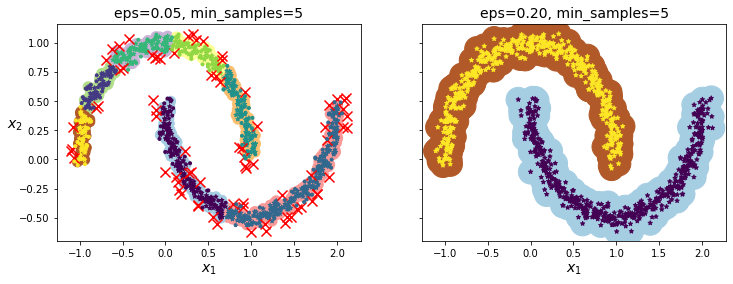

In [58]:
#@title
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

plt.figure(figsize=(12, 4))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

plt.show()

Somewhat surprisingly, the DBSCAN class does not have a `predict()` method,
although it has a `fit_predict()` method. In other words, it cannot predict which cluster a new instance belongs to. The rationale for this decision is that several classification algorithms could make sense here, and it is easy enough to train one, for example a `KNeighborsClassifier`:

In [59]:
from sklearn.neighbors import KNeighborsClassifier

dbscan = dbscan2

knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                     weights='uniform')

Now, given a few new instances, we can predict which cluster they most likely belong to, and even estimate a probability for each cluster. Note that we only trained them on the core instances, but we could also have chosen to train them on all the instances, or all but the anomalies: this choice depends on the final task.

In [60]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
print(knn.predict(X_new))
print(
knn.predict_proba(X_new))

[1 0 1 0]
[[0.18 0.82]
 [1.   0.  ]
 [0.12 0.88]
 [1.   0.  ]]


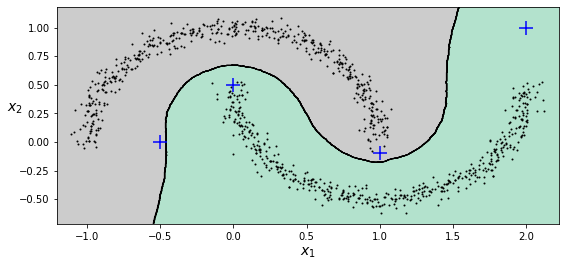

In [61]:
plt.figure(figsize=(9, 4))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
plt.show()

The decision boundary is represented on the previous figure (the crosses represent the $4$ instances in `X_new`). Notice that since there is no anomaly in the KNN’s training set, the classifier always chooses a cluster, even when that cluster is far away. However, it is fairly straightforward to introduce a maximum distance, in which case the two instances that are far away from both clusters are classified as anomalies. To do this, we can use the `kneighbors()` method of the `KNeighborsClassifier`: given a set of instances, it returns the distances and the indices of the $k$ nearest neighbors in the training set (two matrices, each with $k$ columns):

In [62]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  0,  1, -1])

In short, DBSCAN is a very simple yet powerful algorithm, capable of identifying any number of clusters, of any shape, it is robust to outliers, and it has just two hyperparameters (`eps` and `min_samples`). However, if the density varies significantly across the clusters, it can be impossible for it to capture all the clusters properly. Moreover, its computational complexity is roughly $O(m \times log(m))$, making it pretty close to linear with regards to the number of instances. However, Scikit-Learn’s implementation can require up to $O(m^2)$ memory if `eps` is large.

### Other Clustering Algorithms

Scikit-Learn implements several more clustering algorithms that you should take a look at. We cannot cover them all in detail here, but here is a brief overview:

#### Spectral clustering

*Spectral clustering*: this algorithm takes a similarity matrix between the instances and creates a low-dimensional embedding from it (i.e., it reduces its dimensionality), then it uses another clustering algorithm in this low-dimensional space (Scikit-Learn’s implementation uses K-Means). Spectral clustering can capture complex cluster structures, and it can also be used to cut graphs (e.g., to identify clusters of friends on a social network), however it does not scale well to large number of instances, and it does not behave well when the clusters have very different sizes.

In [63]:
from sklearn.cluster import SpectralClustering

sc1 = SpectralClustering(n_clusters=2, gamma=100, random_state=42)
sc1.fit(X)

sc2 = SpectralClustering(n_clusters=2, gamma=1, random_state=42)
sc2.fit(X)

print(np.percentile(sc1.affinity_matrix_, 95))

0.04251990648936265


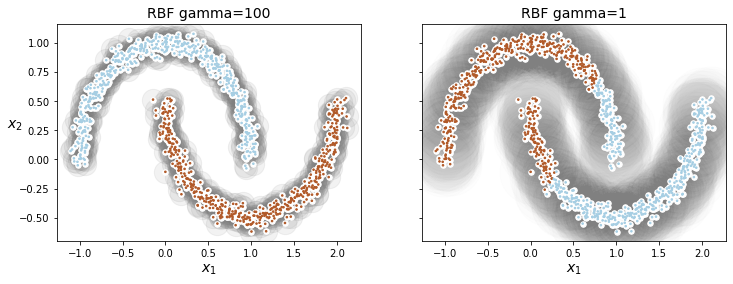

In [64]:
#@title
def plot_spectral_clustering(sc, X, size, alpha, show_xlabels=True, show_ylabels=True):
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=size, c='gray', cmap="Paired", alpha=alpha)
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=30, c='w')
    plt.scatter(X[:, 0], X[:, 1], marker='.', s=10, c=sc.labels_, cmap="Paired")
    
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("RBF gamma={}".format(sc.gamma), fontsize=14)

plt.figure(figsize=(12,4))

plt.subplot(121)
plot_spectral_clustering(sc1, X, size=500, alpha=0.1)

plt.subplot(122)
plot_spectral_clustering(sc2, X, size=4000, alpha=0.01, show_ylabels=False)

plt.show()

#### Agglomerative clustering

*Agglomerative clustering*: a hierarchy of clusters is built from the bottom up. Think of many tiny bubbles floating on water and gradually attaching to each other until there’s just one big group of bubbles. Similarly, at each iteration agglomerative clustering connects the nearest pair of clusters (starting with individual instances). If you draw a tree with a branch for every pair of clusters that merged, you get a binary tree of clusters, where the leaves are the individual instances. This approach scales very well to large numbers of instances or clusters, it can capture clusters of various shapes, it produces a flexible and informative cluster tree instead of forcing you to choose a particular cluster scale, and it can be used with any pairwise distance. It can scale nicely to large numbers of instances if you provide a connectivity matrix. This is a sparse $m$ by $m$ matrix that indicates which pairs of instances are neighbors (e.g., returned by `sklearn.neighbors.kneighbors_graph()`). Without a connectivity matrix, the algorithm does not scale well to large datasets.

In [65]:
from sklearn.cluster import AgglomerativeClustering

X = np.array([0, 2, 5, 8.5]).reshape(-1, 1)
agg = AgglomerativeClustering(linkage="complete").fit(X)

def learned_parameters(estimator):
    return [attrib for attrib in dir(estimator)
            if attrib.endswith("_") and not attrib.startswith("_")]

print(learned_parameters(agg))
print(agg.children_)

['children_', 'labels_', 'n_clusters_', 'n_components_', 'n_connected_components_', 'n_leaves_']
[[0 1]
 [2 3]
 [4 5]]


#### More Clustering Algorithms





- *Birch*: this algorithm was designed specifically for very large datasets, and it can be faster than batch K-Means, with similar results, as long as the number of features is not too large ($< 20$). It builds a tree structure during training containing just enough information to quickly assign each new instance to a cluster, without having to store all the instances in the tree: this allows it to use limited memory, while handle huge datasets.

- *Mean-shift*: this algorithm starts by placing a circle centered on each instance, then for each circle it computes the mean of all the instances located within it, and it shifts the circle so that it is centered on the mean. Next, it iterates this mean-shift step until all the circles stop moving (i.e., until each of them is centered on the mean of the instances it contains). This algorithm shifts the circles in the direction of higher density, until each of them has found a local density maximum. Finally, all the instances whose circles have settled in the same place (or close enough) are assigned to the same cluster. This has some of the same features as DBSCAN, in particular it can find any number of clusters of any shape, it has just one hyperparameter (the radius of the circles, called the bandwidth) and it relies on local density estimation. However, it tends to chop clusters into pieces when they have internal density variations. Unfortunately, its computational complexity is $O(m^2)$, so it is not suited for large datasets.


- *Affinity propagation*: this algorithm uses a voting system, where instances vote for similar instances to be their representatives, and once the algorithm converges, each representative and its voters form a cluster. This algorithm can detect any number of clusters of different sizes. Unfortunately, this algorithm has a computational complexity of $O(m^2)$, so it is not suited for large datasets.

